# Histogram-Based Gradient Boosting (HGBT)

**models may be one of the most useful supervised learning models in scikit-learn. They are based on a modern gradient boosting implementation comparable to LightGBM and XGBoost. As such, HGBT models are more feature rich than and often outperform alternative models like random forests, especially when the number of samples is larger than some ten thousands**

**The top usability features of HGBT models are:**

***Several available loss functions for mean and quantile regression tasks, see Quantile loss.***

***Categorical Features Support, see Categorical Feature Support in Gradient Boosting.***

***Early stopping.***

***Missing values support, which avoids the need for an imputer.***

***Monotonic Constraints.***

***Interaction constraints.***

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error ,mean_absolute_error, r2_score , explained_variance_score

In [2]:
train= pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

In [3]:
train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [4]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# Exploratory Data Analysis & Feature Engineering

Text(0, 0.5, 'Average Price')

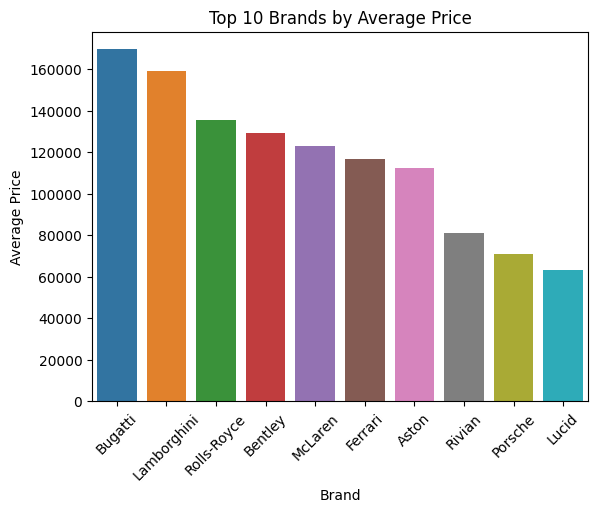

In [5]:
avg_price_by_brand = train.groupby('brand')['price'].mean().sort_values(ascending=False).head(10)  # Top 10 brands by average price
sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values)
plt.title('Top 10 Brands by Average Price')
plt.xticks(rotation=45)
plt.xlabel('Brand')
plt.ylabel('Average Price')

In [6]:
avg_price_by_brand = train.groupby('brand')['price'].mean().sort_values()

luxury_threshold = avg_price_by_brand.quantile(0.67)
economy_threshold = avg_price_by_brand.quantile(0.33)

brand_categories = {}
for brand, price in avg_price_by_brand.items():
    if price >= luxury_threshold:
        brand_categories[brand] = 'luxury'
    elif price >= economy_threshold:
        brand_categories[brand] = 'economy'
    else:
        brand_categories[brand] = 'peasant'

brand_categories

{'Scion': 'peasant',
 'Hummer': 'peasant',
 'MINI': 'peasant',
 'Saturn': 'peasant',
 'Mitsubishi': 'peasant',
 'Subaru': 'peasant',
 'Pontiac': 'peasant',
 'Honda': 'peasant',
 'Mazda': 'peasant',
 'Hyundai': 'peasant',
 'Mercury': 'peasant',
 'Volkswagen': 'peasant',
 'Lotus': 'peasant',
 'Chrysler': 'peasant',
 'Plymouth': 'peasant',
 'Saab': 'peasant',
 'Acura': 'peasant',
 'Toyota': 'peasant',
 'Nissan': 'peasant',
 'Buick': 'economy',
 'Suzuki': 'economy',
 'Lincoln': 'economy',
 'Volvo': 'economy',
 'FIAT': 'economy',
 'Dodge': 'economy',
 'INFINITI': 'economy',
 'Jeep': 'economy',
 'smart': 'economy',
 'Lexus': 'economy',
 'Karma': 'economy',
 'Kia': 'economy',
 'GMC': 'economy',
 'Ford': 'economy',
 'Audi': 'economy',
 'Polestar': 'economy',
 'Chevrolet': 'economy',
 'BMW': 'economy',
 'Cadillac': 'economy',
 'Jaguar': 'luxury',
 'Mercedes-Benz': 'luxury',
 'RAM': 'luxury',
 'Alfa': 'luxury',
 'Land': 'luxury',
 'Genesis': 'luxury',
 'Maybach': 'luxury',
 'Tesla': 'luxury',
 '

In [7]:
train['brand'] = train['brand'].map(brand_categories)

train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,peasant,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,economy,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,economy,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,luxury,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,luxury,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
test['brand'] = test['brand'].map(brand_categories)

test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,luxury,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,luxury,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,economy,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,economy,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,economy,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [9]:
train['engine'] = train['engine'].str.extract(r'(\d+\.\d+)L')[0].astype(float)


In [10]:
test['engine'] = test['engine'].str.extract(r'(\d+\.\d+)L')[0].astype(float)

Text(0, 0.5, 'Average Price')

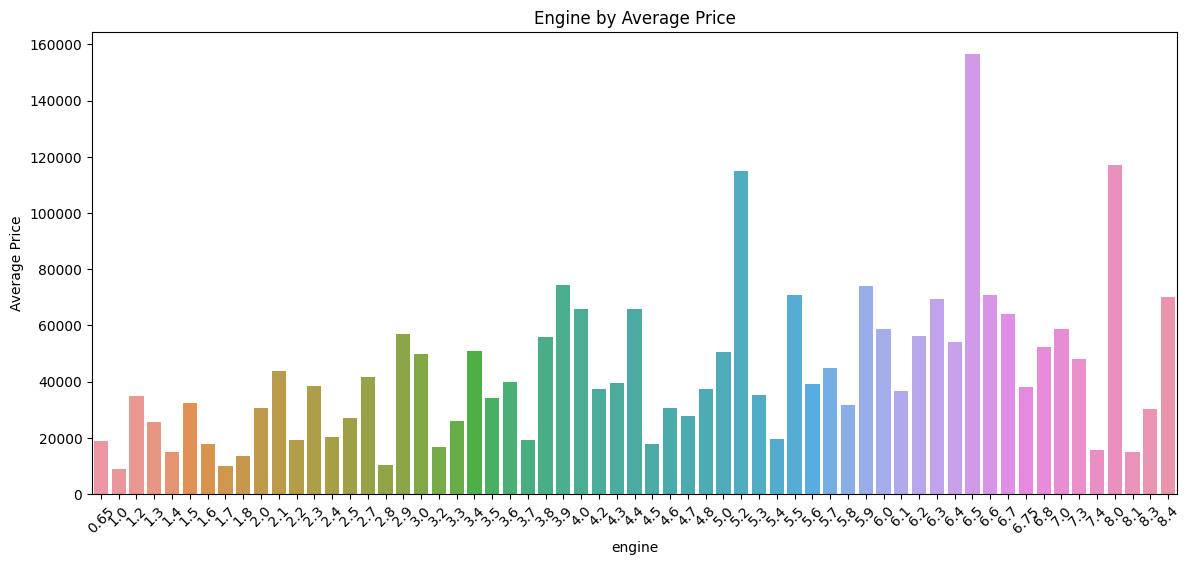

In [11]:
plt.figure(figsize=(14, 6))
avg_price_by_fuel = train.groupby('engine')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_fuel.index, y=avg_price_by_fuel.values)
plt.title('Engine by Average Price')
plt.xticks(rotation=45)
plt.xlabel('engine')
plt.ylabel('Average Price')

In [12]:
train.shape, test.shape

((188533, 13), (125690, 12))

Text(0, 0.5, 'Average Price')

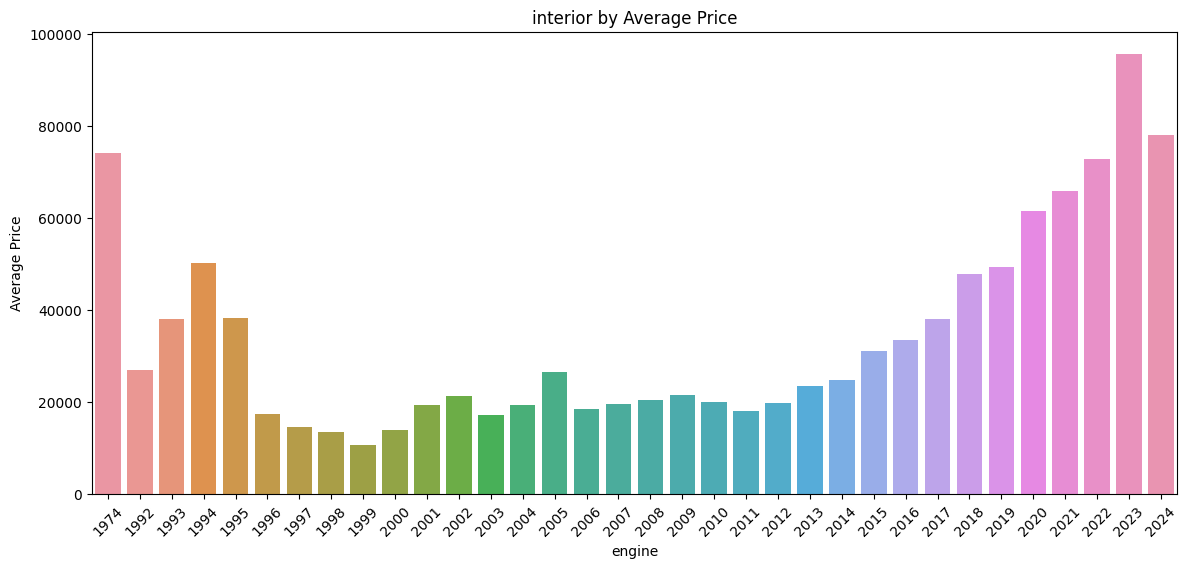

In [13]:
plt.figure(figsize=(14, 6))
avg_price_by_fuel = train.groupby('model_year')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_fuel.index, y=avg_price_by_fuel.values)
plt.title('interior by Average Price')
plt.xticks(rotation=45)
plt.xlabel('engine')
plt.ylabel('Average Price')

In [14]:
model_year_quartiles = train['model_year'].quantile([0.25, 0.5, 0.75])

def categorize_model_year(year):
    if year <= model_year_quartiles[0.25]:
        return 'vintage'
    elif year <= model_year_quartiles[0.5]:
        return 'very old'
    elif year <= model_year_quartiles[0.75]:
        return 'old'
    else:
        return 'almost new'

train['model_year'] = train['model_year'].apply(categorize_model_year)

train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,peasant,Cooper S Base,vintage,213000,Gasoline,1.6,A/T,Yellow,Gray,None reported,Yes,4200
1,1,economy,LS V8,vintage,143250,Gasoline,3.9,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,economy,Silverado 2500 LT,vintage,136731,E85 Flex Fuel,5.3,A/T,Blue,Gray,None reported,Yes,13900
3,3,luxury,G90 5.0 Ultimate,very old,19500,Gasoline,5.0,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,luxury,Metris Base,almost new,7388,Gasoline,2.0,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [15]:
test['model_year'] = test['model_year'].apply(categorize_model_year)

test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,luxury,Rover LR2 Base,very old,98000,Gasoline,2.0,6-Speed A/T,White,Beige,None reported,Yes
1,188534,luxury,Rover Defender SE,old,9142,Hybrid,3.0,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,economy,Expedition Limited,almost new,28121,Gasoline,3.5,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,economy,A6 2.0T Sport,very old,61258,Gasoline,NaN,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,economy,A6 2.0T Premium Plus,old,59000,Gasoline,2.0,A/T,Gray,Black,None reported,Yes


Text(0, 0.5, 'Average Price')

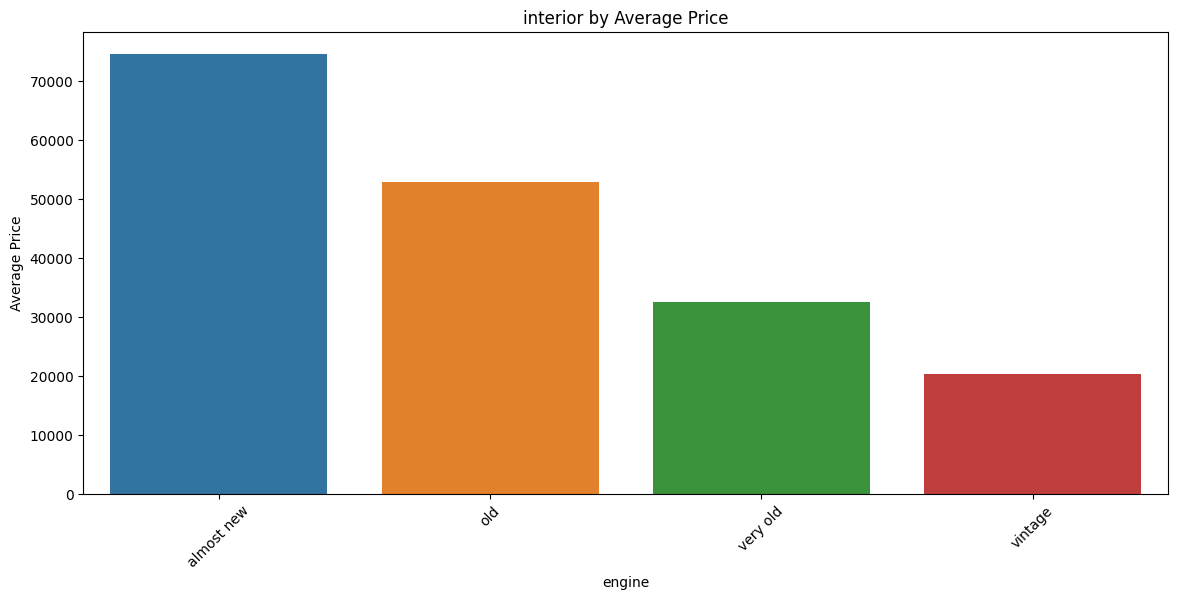

In [16]:
plt.figure(figsize=(14, 6))
avg_price_by_fuel = train.groupby('model_year')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_fuel.index, y=avg_price_by_fuel.values)
plt.title('interior by Average Price')
plt.xticks(rotation=45)
plt.xlabel('engine')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

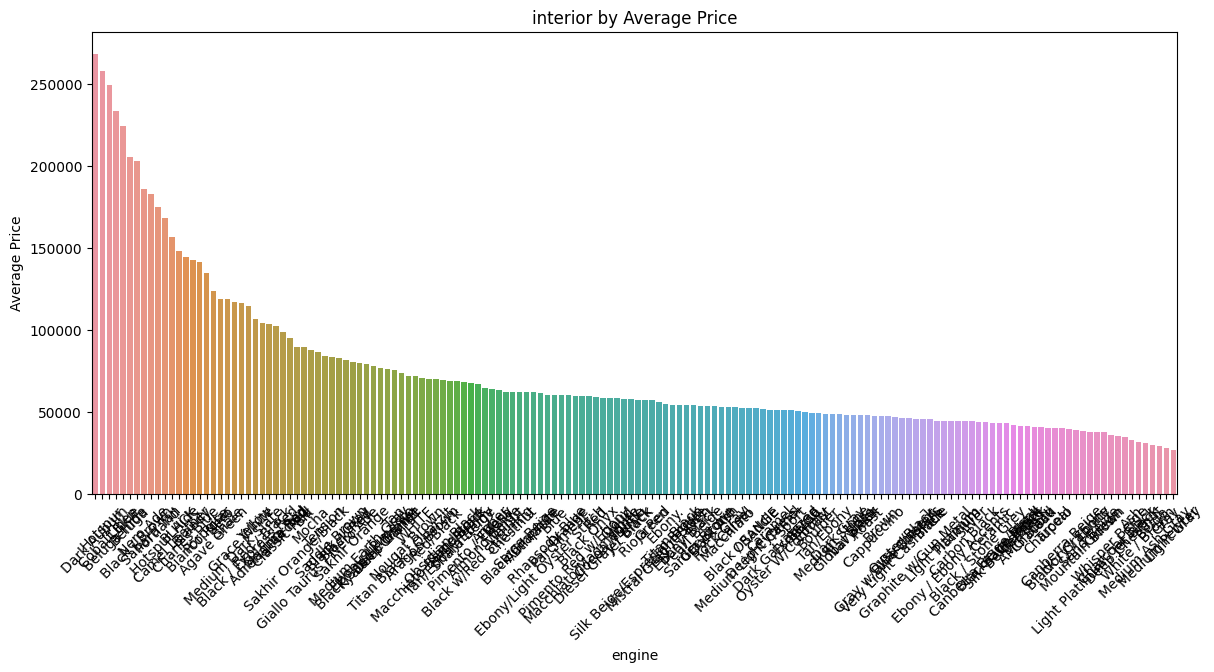

In [17]:
plt.figure(figsize=(14, 6))
avg_price_by_fuel = train.groupby('int_col')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_fuel.index, y=avg_price_by_fuel.values)
plt.title('interior by Average Price')
plt.xticks(rotation=45)
plt.xlabel('engine')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

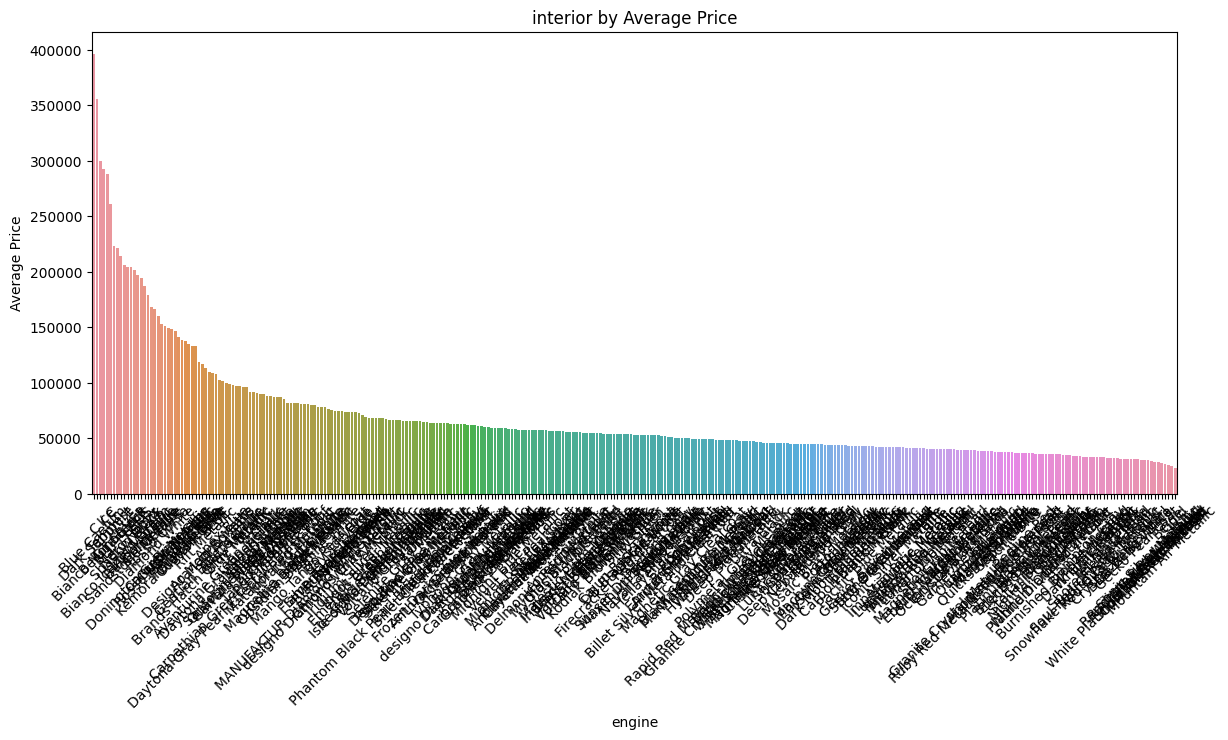

In [18]:
plt.figure(figsize=(14, 6))
avg_price_by_fuel = train.groupby('ext_col')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_fuel.index, y=avg_price_by_fuel.values)
plt.title('interior by Average Price')
plt.xticks(rotation=45)
plt.xlabel('engine')
plt.ylabel('Average Price')

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['brand'] = label_encoder.fit_transform(train['brand'])
train['model_year'] = label_encoder.fit_transform(train['model_year'])
train['fuel_type'] = label_encoder.fit_transform(train['fuel_type'])
train['accident'] = label_encoder.fit_transform(train['accident'])
train['transmission'] = label_encoder.fit_transform(train['transmission'])

In [20]:
test['brand'] = label_encoder.fit_transform(test['brand'])
test['model_year'] = label_encoder.fit_transform(test['model_year'])
test['fuel_type'] = label_encoder.fit_transform(test['fuel_type'])
test['accident'] = label_encoder.fit_transform(test['accident'])
test['transmission'] = label_encoder.fit_transform(test['transmission'])

In [21]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,2,Cooper S Base,3,213000,2,1.6,38,Yellow,Gray,1,Yes,4200
1,1,0,LS V8,3,143250,2,3.9,38,Silver,Beige,0,Yes,4999
2,2,0,Silverado 2500 LT,3,136731,1,5.3,38,Blue,Gray,1,Yes,13900
3,3,1,G90 5.0 Ultimate,2,19500,2,5.0,49,Black,Black,1,Yes,45000
4,4,1,Metris Base,0,7388,2,2.0,23,Black,Beige,1,Yes,97500


Removing the lines that fix the NaN values beacuse HGBT has an in-built support for NaN/missing values in the dataset. 

- When the missingness pattern is predictive, the splits can be performed on whether the feature value is missing or not
- During training, the tree grower learns at each split point whether samples with missing values should go to the left
  or right child, 
  based on the   potential gain. When predicting, samples with missing values are assigned to the left or right child consequently
- If no missing values were encountered for a given feature during training, then samples with missing values are
  mapped to whichever child has the most   samples.

In [22]:
train_new = train.drop(['model','id','ext_col','int_col','clean_title'], axis=1, errors='ignore')
#train_new = train_new.apply(lambda x: x.fillna(x.mode()[0]))

In [23]:
test_new = test.drop(['model','id','ext_col','int_col','clean_title'], axis=1, errors='ignore')
#test_new = test_new.apply(lambda x: x.fillna(x.mode()[0]))

In [24]:
train_new.head()

,brand,model_year,milage,fuel_type,engine,transmission,accident,price
0,2,3,213000,2,1.6,38,1,4200
1,0,3,143250,2,3.9,38,0,4999
2,0,3,136731,1,5.3,38,1,13900
3,1,2,19500,2,5.0,49,1,45000
4,1,0,7388,2,2.0,23,1,97500


In [25]:
train_new[['price','milage']] = np.log10(train_new[['price','milage']])

In [26]:
test_new['milage'] = np.log10(test_new['milage'])

In [27]:
#scaler = StandardScaler()

#scaled_milage = scaler.fit_transform(train_new[['milage','price']])
#train_new[['milage','price']] = scaled_milage
#train_new.head()

In [28]:
#scaled_milage_test = scaler.fit_transform(test_new[['milage']])
#test_new[['milage']] = scaled_milage_test

#test_new.head()

In [29]:
y = train_new.pop('price')
x = train_new

In [30]:
x_test_dataset = test_new

In [31]:
x.head()

,brand,model_year,milage,fuel_type,engine,transmission,accident
0,2,3,5.328380,2,1.6,38,1
1,0,3,5.156095,2,3.9,38,0
2,0,3,5.135867,1,5.3,38,1
3,1,2,4.290035,2,5.0,49,1
4,1,0,3.868527,2,2.0,23,1


# Model = HistGradientBoostingRegressor

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

**using the quantile loss. the differentiating feature of HGBT**

In [33]:
model = HistGradientBoostingRegressor(
    loss='quantile',
    learning_rate=0.9,
    quantile=0.5,  
    max_iter=300,
    max_leaf_nodes=31,
    max_depth=10,
    min_samples_leaf=20,
    max_bins=255,
    scoring='loss',
    verbose=0,
    random_state=11
)

In [34]:
fitting = model.fit(x,y)
fitting.score(x, y)

0.6515922135385097

In [35]:
y_pred = model.predict(x_test_dataset)

In [36]:
def model_report(estimator, x, y, cv=3,valid=True):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
  
    X_train, X_test1, y_train, y_test1 = train_test_split(x, y, test_size=0.2,  random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test1,y_test1, test_size=0.2, random_state=42)
    if valid:
        estimator.fit(
        X_train.values, y_train.values,
        eval_set=[(X_valid.values, y_valid.values)],
    )
    else:
        estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R2 Score : {r2.mean():.6f}") 
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE) : {rmse.mean():.6f}")
    pred = estimator.predict(x_test_dataset)
    return pred

In [37]:
y_pred = model.predict(X_test)

In [38]:
y_pred = model_report(model, x, y,valid=False)

    Model: HistGradientBoostingRegressor
R2 Score : 0.630166
Mean Squared Error (MSE): 0.049911672664846495
Mean Absolute Error (MAE): 0.15670318102444164
Root Mean Squared Error (RMSE) : 0.223409


In [39]:
x_test_dataset['id'] = test['id']

In [40]:
y_pred

array([4.22743841, 4.8843285 , 4.74054783, ..., 4.19125528, 4.03907182,
       4.57646307])

In [41]:
y_pred_prices = 10 ** y_pred
y_pred_prices

array([16882.56401917, 76617.59228092, 55023.45102506, ...,
       15532.99783339, 10941.37297496, 37710.56773254])

In [42]:
submission = pd.DataFrame({
    'id': x_test_dataset['id'],
    'prediction': y_pred_prices
})
submission.to_csv('submission.csv', index=False)

In [43]:
submission

,id,prediction
0,188533,16882.564019
1,188534,76617.592281
2,188535,55023.451025
3,188536,25738.720056
4,188537,29161.663865
...,...,...
125685,314218,23172.622192
125686,314219,43508.449885
125687,314220,15532.997833
125688,314221,10941.372975
